# Bayesian inference on the mean and standard deviation of a Gaussian distribution

In this notebook we will start with a very simple example. It is not hierarchical and it is only meant as an introduction to more complex models in subsequent notebooks. 

**The problem:** We have $N$ measurements of a physical quantity, all taken with the same instrument in the same experiment. We thus assume that our measurement uncertainties are equal but unknown. We aim at inferring the true value of the quantity $\mu$ and the associated measurement uncertainty $\sigma$ under the hypothesis that the measurement errors are Gaussian distributed:
$$
x \sim \mathcal{N}(\mu,\sigma)
$$

We start by generating the data that will be used for inference. We generate ten points from a Gaussian distribution centred at 10 and with a standard deviation of 2. These are the model parameters that we aim to infer. We know them because we generate the data for this example.

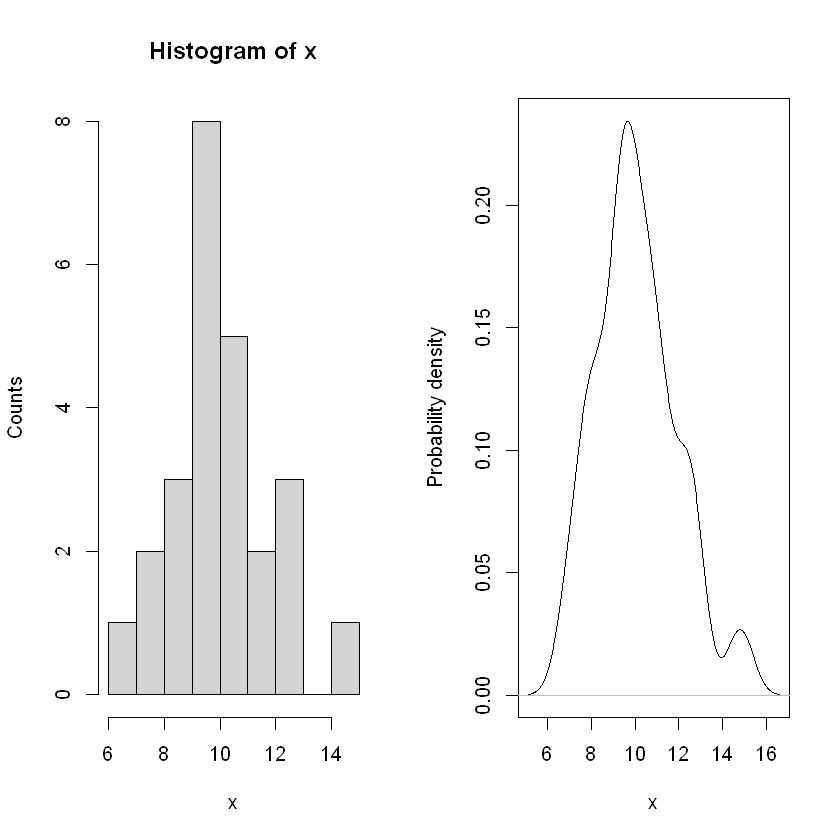

In [1]:
set.seed(0)
x <- rnorm(25,mean = 10, sd = 2)
par(mfcol=c(1,2))
hist(x, xlab="x",ylab="Counts")
plot(density(x),xlab="x",ylab="Probability density",main="")

Now that we have the data, let us come back to the (extremely simple) model for how the data were generated. In this case we know precisely how they were generated but in the general case this will be a creative exercise guided heuristically by our prior knowledge about the problem. Our model has only two parameters: the true value of the physical quantity and the properties of the noise process (the measument uncertainties $\sigma$) that introduces measurement errors. We depict this model using two nodes at the top ($\mu$ and $\sigma$) and the set of observations $\{x_i; i=1,2,N\}$ at the bottom.  

### The likelihood

Remember that the likelihood is defined as the probability of our data given the unknown model parameters: $p(\{x_i\}\mid\mu,\sigma)$. 

In our case and according to the problem definition, we hypothesize that the measurements follow a Gaussian distribution centred at the true value and with a standard deviation $\sigma$. Hence

$$
p(\{x_i\}\mid\mu,\sigma)= \prod_{i=1}^N \frac{1}{\sqrt{(2\pi)}\sigma^2}\exp(-\frac{(x_i-\mu)^2}{2\sigma^2})
$$

Hence, if we knew the values of $\mu$ and $\sigma$ we could compute it easily using the Gaussian probability density. But we don't. That is precisely what we aim to infer, and the likelihood is but one character in the bayesian dramma. What bayesian inference allows us is precisely that: to infer the (distribution of the) parameters of interest given the observations. This is what we call the posterior probability which in this case is $p(\mu, \sigma\mid\{x_i\})$. According to Bayes' theorem:

$$
p(\mu, \sigma\mid\{x_i\}) = \frac{p(\{x_i\}\mid\mu,\sigma)\cdot(p(\mu,\sigma))}{p(\{x_i\})}
$$

Let us write the code to compute the likelihood:

In [2]:
likelihood <- function(mu,sigma) 
    {
    likvec = mapply(dnorm,mean = mu,sd = sigma,x=x) # This is a vector containing the probability densities for each observation
    return(prod(likvec))
}


### The prior

We have already defined the likelihood analytically so we can compute its value for any given pair of values 
$\mu$ and $\sigma$. The next two characters in the Bayesian dramma are the prior $p(\mu,\sigma)$ and the evidence $p\{x_i\}$. The latter is a scalar (a real number in this context) independent of the values of $\mu$ and $\sigma$. That is to say, it is the same for all values of $\sigma$ and $\mu$. It acts as a normalization constant that ensures that the posterior probability is properly normalized (if that is at all possible; see the concept of improper distribution in the textbook). So for the time being we will just neglect this normalization constant. This is fine as long as we do not need to select amongst competing models and aim only at inferring the posterior distribution.

Then the only element left for a determination of the posterior probabilities for any value of the model parameters is the prior. I will skip here all the controversy about frequentist/bayesian inference and simply define a proper non-informative prior. Actually two: a uniform prior in a bounded interval and a Gaussian prior with a large standard deviation. How we define the prior is dependent on the problem that we attempt to solve. It is supposed to encompass our knowledge about the parameters before any data is acquired. If our measuments were measurements of the speed of a moving bicycle, I'd say that a uniform prior between 2 km/h and 100 km/h is a sensible choice. At smaller velocities the bicycle falls and, unless you measure the speed of a Tour de France cyclist descending Tourmalet, it should plausibly contain the true value. If something else is known like, for example that the cyclist is a 7 years old kid, we can narrow down the prior by specifying that our prior belief can be captured by a Gaussian probability centred at 7 km/h with a large standard deviation like 10 km/h. Notice that this allows for positive probability densities at negative values of the speed. Let us try both for our data set.    


### The posterior

Now, for the uniform prior we have that the posterior probability density is given by 

In [50]:
prior <- function(mu,sigma){
    if (mu <= 3| mu>100) priorMu = 0 else priorMu = (1/97)
    if (sigma <=0 | sigma > 100) priorSigma = 0 else priorSigma = 1/sigma
    prior = priorMu*priorSigma
    return(prior)
}

posterior <- function(mu,sigma){likelihood(mu,sigma)*prior(mu,sigma)}

Finally, let us define a grid of values of $\mu$ and $\sigma$ and compute the posterior probabilities for each of the grid nodes:

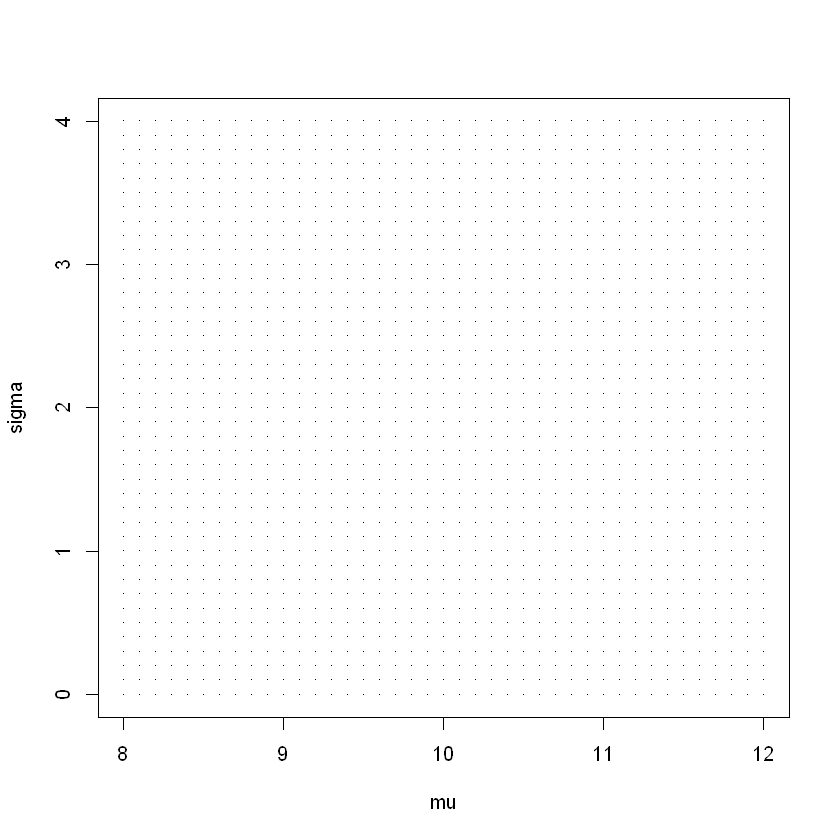

In [51]:
# Define the grid axes
grid.mu <- seq(8,12,by=0.1)
grid.sigma <- seq(0,4,by=0.1)
# Use them to create the grid (for plotting purposes)
grid <- expand.grid(grid.mu,grid.sigma)
colnames(grid) <- c("mu","sigma")
plot(grid,pch=".")

# Now, compute the posterior at the grid nodes.
ni=length(grid.mu)
nj=length(grid.sigma)
post <- matrix(NA,nrow =nj, ncol = ni)
for (i in nj:1)
    {
    for (j in 1:ni)
        {        
        post[i,j] <- posterior(grid.mu[j],grid.sigma[i])
        }
    }

Let us visualize the inferred posterior:

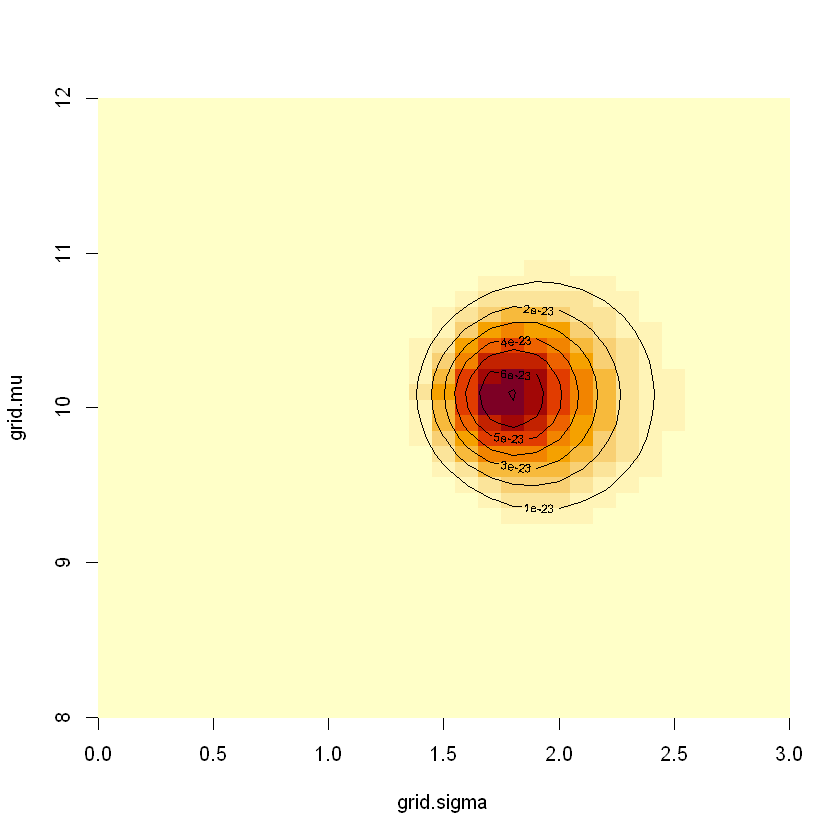

In [52]:
image(grid.sigma,grid.mu,post,xlim=c(0,3),ylim=c(8,12))
contour(grid.sigma,grid.mu,post,add=T) # Add contour lines

Now, here are a few suggestions for further exploration of this very simple example:
* What can we say about the posterior as compared to the true values? Is there a bias? 
* With the same data... how does the posterior change if we use a Gaussian prior for the true value of the measured quantity (as opposed to the uniform prior)?
* How does the posterior change if we decrease/increase the number of measurements?
* What happens if we keep a small number of measurements and generate different (say 10) random seeds for generating the data?
* Is there an analytic expression for the posterior?

And finally... imagine a setup where your instrument is unable to measure values above or below a certain value. For example, think of a measurement device that cannot measure values above 10.2 and for those cases you only have an upper limit: the measurent is above 10.2 but its value is unavailable. This is called censoring. How would you attempt to infer the two model parameters in this situation? In an alternative setup your measurement instrument is not triggered by measurements above or below a certain value (truncation). The difference with respect to censoring is that we do not know how many measurements would be missing (but we know the detection threshold). How would you attempt inference in this case?


# My solutions

###  What can we say about the posterior as compared to the true values? Is there a bias? 

We can sample from the posterior using grid approximation.

In [53]:
library(tidyverse)
post_samples <- sample_n(grid, size=10000, weight=post, replace=T) %>% 
    mutate(x_pred = rnorm(n(), mean=mu, sd=sigma)) %>% as_tibble()

head(post_samples)


mu,sigma,x_pred
<dbl>,<dbl>,<dbl>
10.4,2.2,7.835331
9.7,2.2,10.728112
9.7,1.9,11.411805
9.6,1.9,9.928383
10.0,2.4,10.710905
9.7,2.0,10.227092


In [54]:

post_samples %>% summarise(x_pred_mean = mean(x_pred), x_pred_sd = sd(x_pred))

x_pred_mean,x_pred_sd
<dbl>,<dbl>
9.896811,2.152563


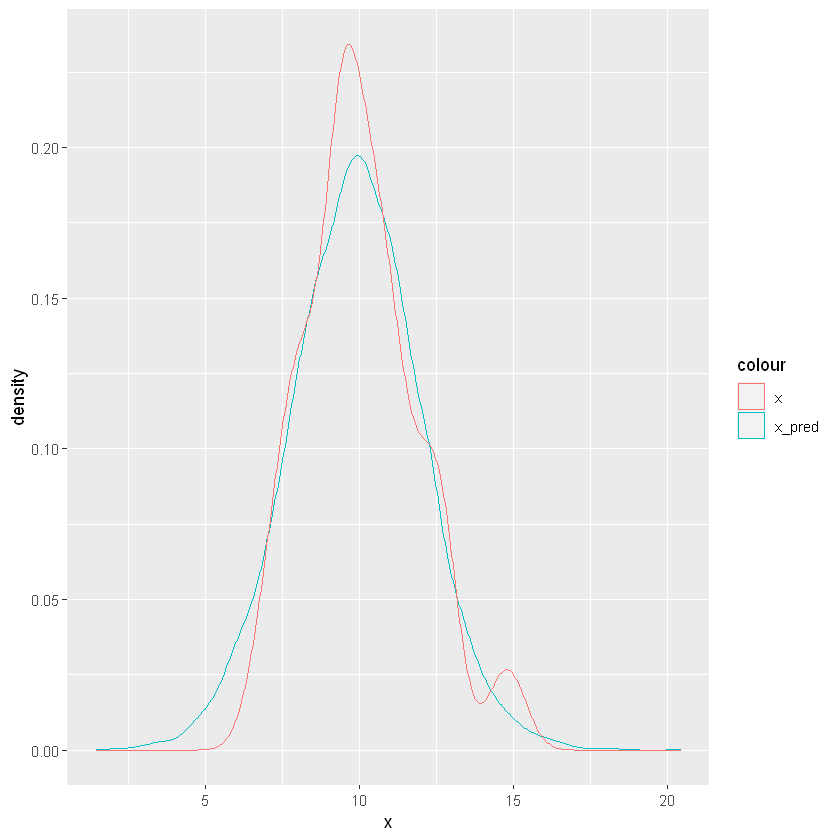

In [10]:
library(ggplot2)
post_samples %>% ggplot() + 
    geom_density(aes(x = x_pred, color="x_pred")) + 
    geom_density(data=as_tibble(x), aes(x=value, color="x")) +
    xlab("x")


### With the same data... how does the posterior change if we use a Gaussian prior for the true value of the measured quantity (as opposed to the uniform prior)?

In [37]:
log_likelihood2 <- function(mu,sigma) 
    {
    likvec = mapply(dnorm,mean = mu,sd = sigma,x=x, log=T) # This is a vector containing the probability densities for each observation
    return(sum(likvec))
}

log_prior2 <- function(mu,sigma){
    priorMu = dnorm(mu, 7, 10, log=T)
    if (sigma <=0 | sigma > 100) priorSigma = 0 else priorSigma = 1/sigma
    prior = priorMu+priorSigma
    return(prior)
}

log_posterior2 <- function(mu,sigma){log_likelihood2(mu,sigma) + log_prior2(mu,sigma)}

In [38]:
log_post2 <- matrix(NA,nrow =nj, ncol = ni)
for (i in nj:1)
    {
    for (j in 1:ni)
        {   
        log_post2[i,j] <- log_posterior2(grid.mu[j],grid.sigma[i])
        }
    }


In [39]:
post2 <- exp(log_post2)

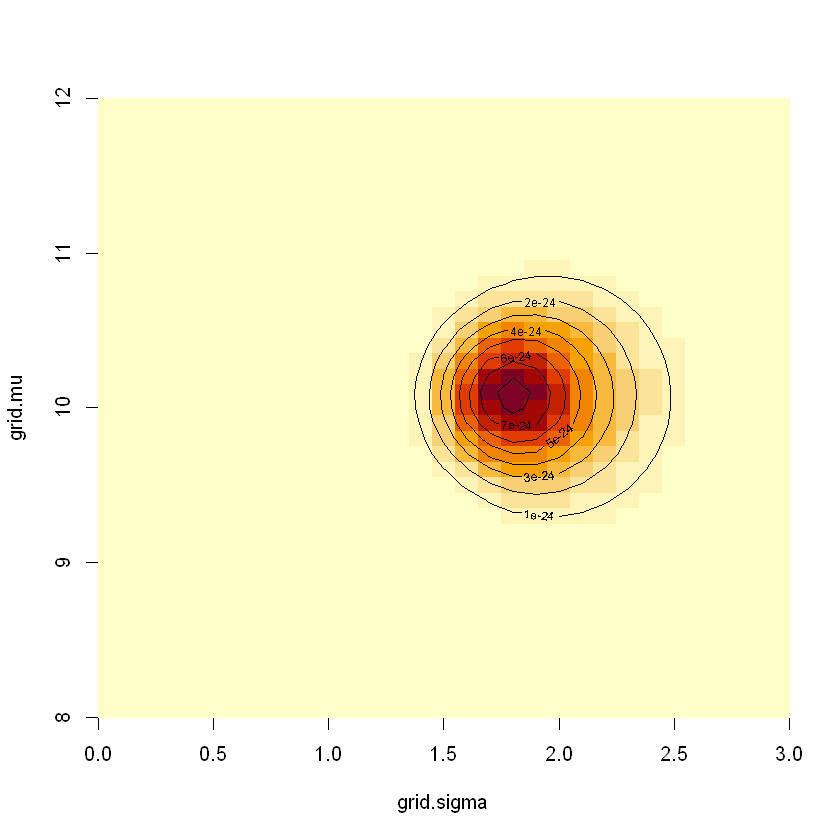

In [40]:
image(grid.sigma,grid.mu,post2,xlim=c(0,3),ylim=c(8,12))
contour(grid.sigma,grid.mu,post2,add=T) # Add contour lines

In [41]:
post2_samples <- sample_n(grid, size=10000, weight=post2, replace=T) %>% 
    mutate(x2_pred = rnorm(n(), mean=mu, sd=sigma)) %>% as_tibble()

head(post2_samples)


mu,sigma,x2_pred
<dbl>,<dbl>,<dbl>
10.1,1.5,8.854385
9.9,2.3,8.716023
9.8,2.6,13.966029
9.6,1.7,9.642455
9.7,1.9,9.264134
9.8,2.0,9.811861


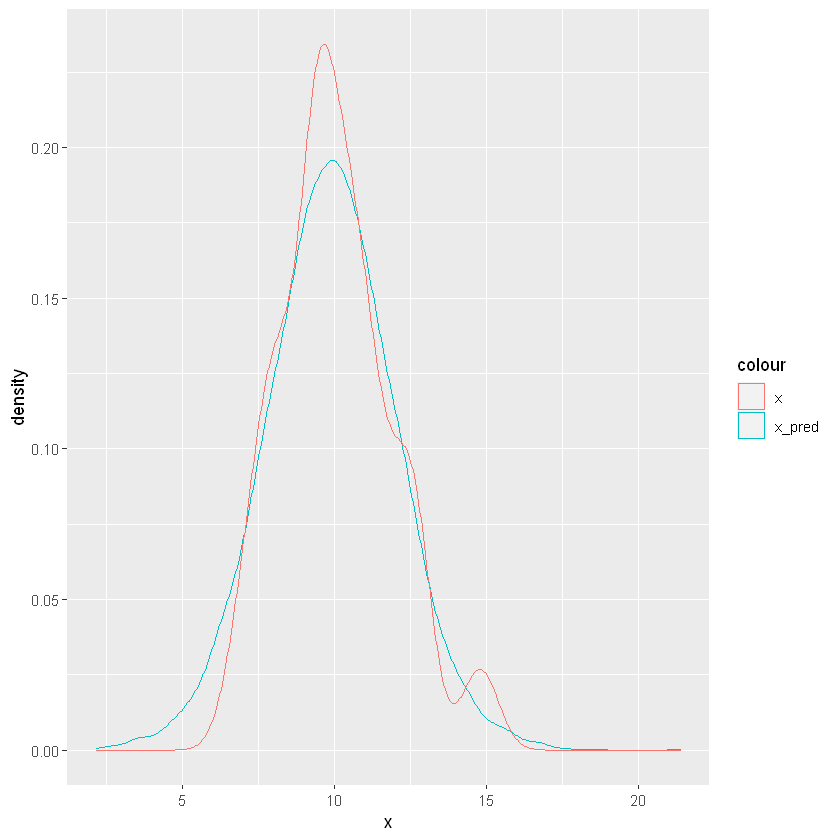

In [42]:
post2_samples %>% ggplot() + 
    geom_density(aes(x = x2_pred, color="x_pred")) + 
    geom_density(data=as_tibble(x), aes(x=value, color="x")) +
    xlab("x")

In [43]:
post2_samples %>% summarise(x2_pred_mean = mean(x2_pred), x2_pred_sd = sd(x2_pred))

x2_pred_mean,x2_pred_sd
<dbl>,<dbl>
9.909099,2.130289


In [30]:
post_samples %>% summarise(x_pred_mean = mean(x_pred), x_pred_sd = sd(x_pred))

x_pred_mean,x_pred_sd
<dbl>,<dbl>
9.900237,2.1101


### How does the posterior change if we decrease/increase the number of measurements?

In [18]:
x3 <- rnorm(300,mean = 10, sd = 2)

log_likelihood3 <- function(mu,sigma) 
    {
    likvec = mapply(dnorm,mean = mu,sd = sigma,x=x3, log=T) # This is a vector containing the probability densities for each observation
    return(sum(likvec))
}

log_prior3 <- function(mu,sigma){
    if (mu <= 3| mu>100) priorMu = 0 else priorMu = log(1/97)
    if (sigma <=0 | sigma > 100) priorSigma = 0 else priorSigma = 1/sigma
    prior = priorMu+priorSigma
    return(prior)
}

log_posterior3 <- function(mu,sigma){log_likelihood3(mu,sigma) + log_prior3(mu,sigma)}

In [19]:
log_post3 <- matrix(NA,nrow =nj, ncol = ni)
for (i in nj:1)
    {
    for (j in 1:ni)
        {        
        log_post3[i,j] <- log_posterior3(grid.mu[j],grid.sigma[i])
        }
    }

In [20]:
post3 = exp(log_post3)

In [21]:
post3_samples <- sample_n(grid, size=10000, weight=post3, replace=T) %>% 
    mutate(x3_pred = rnorm(n(), mean=mu, sd=sigma)) %>% as_tibble()

head(post3_samples)


mu,sigma,x3_pred
<dbl>,<dbl>,<dbl>
10.2,1.9,9.097584
10.3,1.9,8.639377
10.1,1.9,10.316113
10.1,1.9,9.017736
10.1,1.9,11.143271
10.1,2.0,6.933404


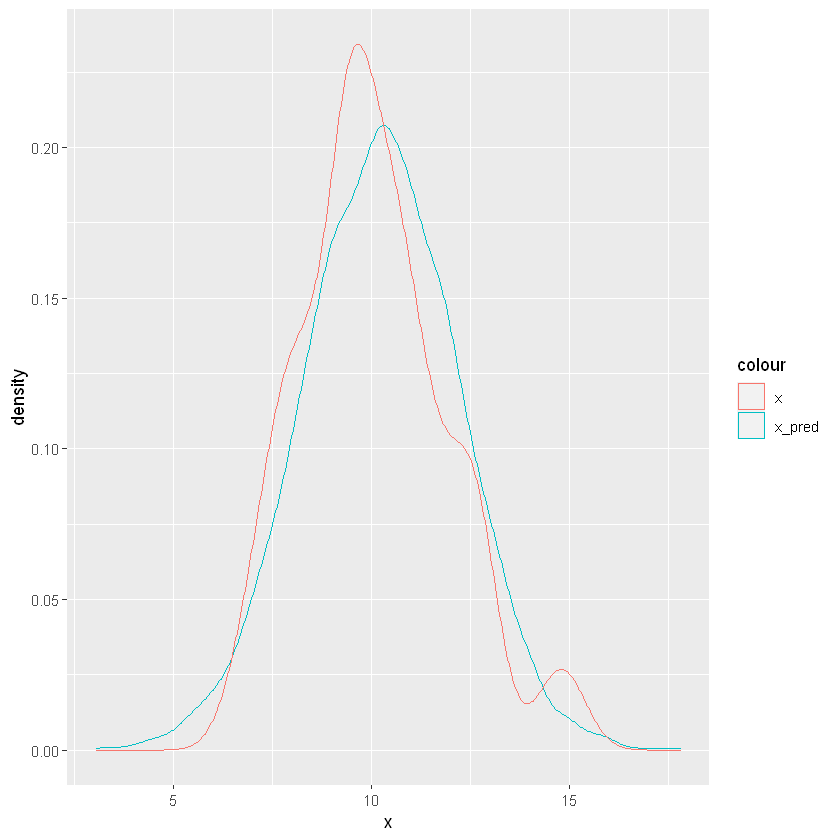

In [22]:
post3_samples %>% ggplot() + 
    geom_density(aes(x = x3_pred, color="x_pred")) + 
    geom_density(data=as_tibble(x), aes(x=value, color="x")) +
    xlab("x")

In [363]:
post3_samples %>% summarise(x3_pred_mean = mean(x3_pred), x3_pred_sd = sd(x3_pred))

x3_pred_mean,x3_pred_sd
<dbl>,<dbl>
10.11975,1.910284


In [44]:
log_likelihood4 <- function(mu,sigma) 
    {
    likvec = mapply(dnorm,mean = mu,sd = sigma,x=x3, log=T) # This is a vector containing the probability densities for each observation
    return(sum(likvec))
}

log_prior4 <- function(mu,sigma){
    priorMu = dnorm(mu, 7, 10, log=T)
    if (sigma <=0 | sigma > 100) priorSigma = 0 else priorSigma = 1/sigma
    prior = priorMu+priorSigma
    return(prior)
}

log_posterior4 <- function(mu,sigma){log_likelihood4(mu,sigma) + log_prior4(mu,sigma)}

In [45]:
log_post4 <- matrix(NA,nrow =nj, ncol = ni)
for (i in nj:1)
    {
    for (j in 1:ni)
        {        
        log_post4[i,j] <- log_posterior4(grid.mu[j],grid.sigma[i])
        }
    }

In [46]:
post4 = exp(log_post4)

In [47]:
post4_samples <- sample_n(grid, size=10000, weight=post4, replace=T) %>% 
    mutate(x4_pred = rnorm(n(), mean=mu, sd=sigma)) %>% as_tibble()

head(post4_samples)


mu,sigma,x4_pred
<dbl>,<dbl>,<dbl>
10.0,1.9,12.372215
10.2,1.9,9.529121
10.3,2.0,9.869182
10.3,2.0,7.067200
10.3,1.9,12.794134
10.2,1.8,9.922830


In [48]:
post4_samples %>% summarise(x4_pred_mean = mean(x4_pred), x4_pred_sd = sd(x4_pred))

x4_pred_mean,x4_pred_sd
<dbl>,<dbl>
10.21339,1.956409


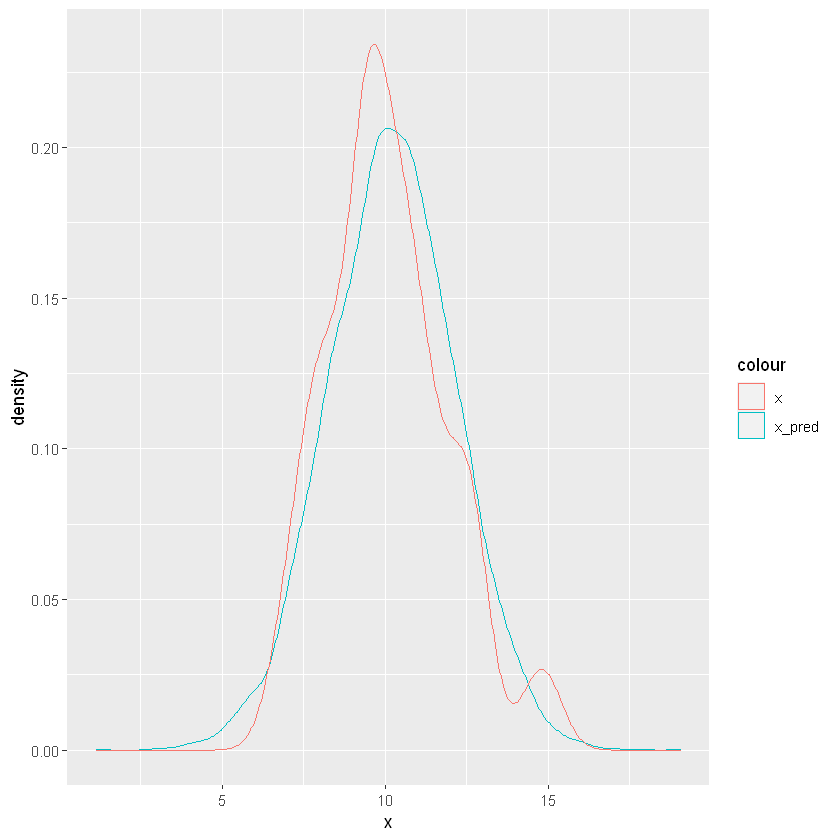

In [49]:
post4_samples %>% ggplot() + 
    geom_density(aes(x = x4_pred, color="x_pred")) + 
    geom_density(data=as_tibble(x), aes(x=value, color="x")) +
    xlab("x")

### What happens if we keep a small number of measurements and generate different (say 10) random seeds for generating the data?

### Is there an analytic expression for the posterior?

\begin{equation}
\begin{split}
p(\mu, \sigma\mid\{x_i\}) & = \frac{p(\{x_i\}\mid\mu,\sigma)\cdot(p(\mu,\sigma))}{p(\{x_i\})} \propto p(\{x_i\}\mid\mu,\sigma)\cdot(p(\mu,\sigma)) \propto p(\{x_i\}\mid\mu,\sigma)\cdot p(\mu) \cdot p(\sigma) \\
& \propto \frac{1}{a} \cdot \frac{1}{\sigma} \cdot \prod_{i=1}^N \frac{1}{\sqrt{(2\pi)}\sigma^2}\exp(-\frac{(x_i-\mu)^2}{2\sigma^2}) 
\propto \frac{1}{\sigma^{N+1}} \cdot \exp(-\sum_{i=1}^N \frac{(x_i-\mu)^2}{2\sigma^2}) 
\end{split}
\end{equation}

